In [3]:
import numpy as np
import h5py
import math
#from sklearn.decomposition import PCA
#from pca import pca
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#from tqdm import tqdm
#import peakutils
import os, sys
#from BaselineRemoval import BaselineRemoval
#from sklearn.cluster import DBSCAN
import random
import scipy

In [4]:
# H5 file to read
h5_path = "/mnt/analysis/e17023/Adam/GADGET2/simOutput/"
f = h5py.File(h5_path + '273_800p.h5', 'r')
h5file = f

In [5]:
class HiddenPrints:
	def __enter__(self):
		self._original_stdout = sys.stdout
		sys.stdout = open(os.devnull, 'w')

	def __exit__(self, exc_type, exc_val, exc_tb):
		sys.stdout.close()
		sys.stdout = self._original_stdout

def remove_outliers(xset, yset, zset, eset, threshold):
	"""
	Uses DBSCAN to find and remove outliers in 3D data
	"""
 
	data = np.array([xset.T, yset.T, zset.T]).T
 
	# STANDARD METHOD
	#DBSCAN_cluster = DBSCAN(eps=7, min_samples=10).fit(data)
	#out_of_cluster_index = np.where(DBSCAN_cluster.labels_==-1)

	# FISHTANK METHOD
	labels = dbscan(data, eps=7, min_samples=10)
	out_of_cluster_index = np.where(labels==-1)

	del data
	rev = out_of_cluster_index[0][::-1]
	#if len(out_of_cluster_index[0]) > 0:
	for i in rev:
		xset = np.delete(xset, i)
		yset = np.delete(yset, i)
		zset = np.delete(zset, i)
		eset = np.delete(eset, i)

	if len(xset) <= threshold:
		veto = True
	else:
		veto = False

	return xset, yset, zset, eset, veto

In [6]:
def dbscan(X, eps, min_samples):
    # Initialize variables
    labels = np.zeros(X.shape[0])
    cluster = 0

    # Compute distances between points
    dists = np.sqrt(((X[:, np.newaxis] - X) ** 2).sum(axis=2))

    # Iterate over each point
    for i in range(X.shape[0]):
        # If point already visited, continue
        if labels[i] != 0:
            continue

        # Find neighboring points
        neighbors = np.where(dists[i] <= eps)[0]

        # If not enough neighboring points, label as noise
        if len(neighbors) < min_samples:
            labels[i] = -1
            continue

        # Expand cluster
        cluster += 1
        labels[i] = cluster

        while len(neighbors) > 0:
            j = neighbors[0]
            if labels[j] == -1:
                labels[j] = cluster
            elif labels[j] == 0:
                labels[j] = cluster
                new_neighbors = np.where(dists[j] <= eps)[0]
                if len(new_neighbors) >= min_samples:
                    neighbors = np.concatenate((neighbors, new_neighbors))
            neighbors = neighbors[1:]

    return labels

In [7]:
def pca_func(data, n_components):
    
    # original method
    #pca = PCA(n_components=n_components)
    #pca.fit(data)
    #out = pca.transform(data)

    
    # fishtank-compatible method
    # Subtract the mean from the data to center it
    mean = np.mean(data, axis=0)
    data_centered = data - mean

    # Compute the covariance matrix
    cov = np.cov(data_centered, rowvar=False)

    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigvals, eigvecs = np.linalg.eig(cov)

    # Transform the data into the new coordinate system defined by the eigenvectors
    out = np.dot(data_centered, eigvecs)

    return out

In [8]:
print('Veto on Length @ 70 mm')
print('Veto on Integrated Charge @ 800k')
def track_len(xset, yset, zset):
    """
    Uses PCA to find the length of a track
    """
    veto_on_length = False
 
    # Form data matrix
    data = np.concatenate((xset[:, np.newaxis], 
                           yset[:, np.newaxis], 
                           zset[:, np.newaxis]), 
                           axis=1)

    # Use PCA to find track length
    principalComponents = pca_func(data, 3)
    
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    track_len = 2.35*principalDf.std()[0]
    if track_len > 70:
        veto_on_length = True
    
    # Force no veto for testing
    veto_on_length = False
    
    return track_len, veto_on_length


def main(h5file, threshold):
    """
    This functions does the following: 
    - Converts h5 files into ndarrays. 
    - Removes outliers.
    - Calls PCA to return track length.
    - Sums mesh signal to return energy.
    """
    # Converts h5 files into ndarrays, and output each event dataset as a separte list
    num_events = int(len(list(h5file.keys()))/2) 
    
    len_list = []
    good_events = []
    tot_energy = []
    skipped_events = 0
    veto_events = 0
    
    # pbar = tqdm(total=num_events+1)
    for i in range(0, num_events):
        str_event = f"Event_[{i}]"
        
        # Apply pad threshold
        event = np.array(h5file[str_event][:])
        if len(event) <= threshold:
            skipped_events += 1
            # pbar.update(n=1)
            continue
            
        # Make copy of datasets
        dset_0_copyx = event['x'] 
        dset_0_copyy = event['y'] 
        dset_0_copyz = event['z'] - min(event['z'])
        dset_0_copye = event['A']

        
        # Apply veto condition
        R = 36                           # Radius of the pad plane
        r = np.sqrt(dset_0_copyx**2 + dset_0_copyy**2)
        statements = np.greater(r, R)    # Check if any point lies outside of R
      
        if np.any(statements) == True:
            veto_events += 1
            # pbar.update(n=1)
            continue
        
        
        # Call remove_outliers to get dataset w/ outliers removed
        dset_0_copyx, dset_0_copyy, dset_0_copyz, dset_0_copye, veto = remove_outliers(dset_0_copyx, dset_0_copyy, dset_0_copyz, dset_0_copye, threshold)
        if veto == True:
            skipped_events += 1
            # pbar.update(n=1)
            continue

        
        # Call track_len() to create lists of all track lengths
        length, veto_on_length = track_len(dset_0_copyx, dset_0_copyy, dset_0_copyz)
        if veto_on_length == True:
            veto_events += 1
            # pbar.update(n=1)
            continue
                
       	str_trace = f"Trace_[{i}]"
        trace = np.array(h5file[str_trace][:])
        max_val = np.argmax(trace)
        low_bound = max_val - 75
        if low_bound < 0:
            low_bound = 5
        upper_bound = max_val + 75
        if upper_bound > 511:
            upper_bound = 506
        trace = trace[low_bound:upper_bound]

        polynomial_degree=2 
        # STANDARD METHOD
        #baseObj=BaselineRemoval(trace)
        #trace=baseObj.IModPoly(polynomial_degree)
        # FISHTANK METHOD
        # determine the width of the peak in the trace and the location of the peak
        peakloc = np.argmax(trace)
        
        peakwidth1 = 0
        peakwidth2 = 0
        i = peakloc
        while trace[i] > np.min(trace) + np.std(trace):
            peakwidth1 += 1
            i += 1
        i = peakloc
        while trace[i] > np.min(trace) + np.std(trace):
            peakwidth2 += 1
            i -= 1
        # calculate the average of the trace outside of the peakwidth window on either side of the peak
        baseline = np.mean(np.concatenate((trace[:peakloc-peakwidth2], trace[peakloc+peakwidth1:])))
        # subtract the baseline from the trace
        trace = trace - baseline

        # Apply veto on integrated charge, disabled for testing
        #if np.sum(trace) > 800000:
        #    veto_events += 1
        #    pbar.update(n=1)
        #    continue

        len_list.append(length)
        tot_energy.append(np.sum(trace))

        # Track event number of good events
        good_events.append(i)  
        # pbar.update(n=1)

    return (tot_energy, skipped_events, veto_events, good_events, len_list)

Veto on Length @ 70 mm
Veto on Integrated Charge @ 800k


C:\Users\Adam\AppData\Local\Temp\ipykernel_19344\1839549507.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


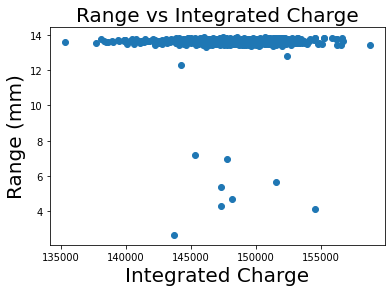

In [9]:
# Call function to create images
(tot_energy, skipped_events, veto_events, good_events, len_list) = main(h5file=f, threshold=15)

# Plot range as a function of energy 
f = plt.figure(1)
plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel('Integrated Charge',fontdict = {'fontsize' : 20})
plt.ylabel('Range (mm)',fontdict = {'fontsize' : 20})
plt.title('Range vs Integrated Charge',fontdict = {'fontsize' : 20})
plt.scatter(tot_energy, len_list)
f.show()

C:\Users\Adam\AppData\Local\Temp\ipykernel_19344\3468383827.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


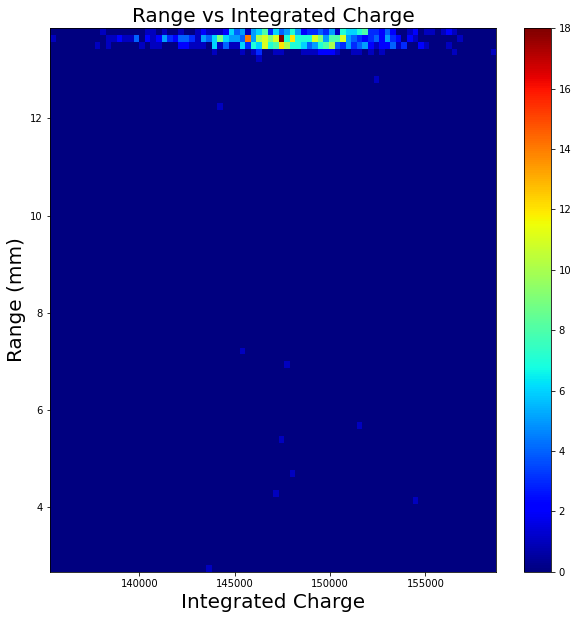

In [10]:
# Plot 2D histogram of range vs energy
g = plt.figure(2)
plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel('Integrated Charge',fontdict = {'fontsize' : 20})
plt.ylabel('Range (mm)',fontdict = {'fontsize' : 20})
plt.title('Range vs Integrated Charge',fontdict = {'fontsize' : 20})
#plt.hist2d(tot_energy, len_list, (50, 50), cmap=plt.cm.jet)
plt.hist2d(tot_energy, len_list, (80, 80), cmap=plt.cm.jet)
#plt.hist2d(tot_energy, len_list, (100, 100), cmap=plt.cm.jet)
plt.colorbar()
g.show()

plt.show()

In [11]:
def make_grid():
    """
    "Create Training Data.ipynb"eate grid matrix of MM outline and energy bar, see spreadsheet below
    https://docs.google.com/spreadsheets/d/1_bbg6svfEph_g_Z002rmzTLu8yjQzuj_p50wqs7mMrI/edit?usp=sharing
    """
    row = np.array([63, 47, 39, 31, 27, 23, 19, 15, 15, 11, 11, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 7, 7, 
					    7, 7, 11, 11, 15, 15, 19, 23, 27, 31, 39, 47, 63]) 
    
    to_row = np.array([87, 103, 111, 119, 123, 127, 131, 135, 135, 139, 139, 143, 143, 143, 143, 147, 
					       147, 147, 147, 147, 147, 148, 143, 143, 143, 144, 139, 140, 135, 136, 132, 128,
					       124, 120, 112, 104, 88]) 
    
    col = np.array([100, 84, 76, 68, 64, 60, 56, 52, 52, 48, 48, 44, 44, 44, 44, 40, 40, 40, 40, 40, 
					    40, 40, 44, 44, 44, 44, 48, 48, 52, 52, 56, 60, 64, 68, 76, 84, 100])
    
    to_col = np.array([124, 140, 148, 156, 160, 164, 168, 172, 172, 176, 176, 180, 180, 180, 180, 184, 
					       184, 184, 184, 184, 184, 184, 180, 180, 180, 180, 176, 176, 172, 172, 168, 164, 
					       160, 156, 148, 140, 124]) 
    
    all_row = np.array([i for i in range(3, 148, 4)])
    all_col = np.array([i for i in range(40, 185, 4)]) 

    full_image_size_width = 224
    full_image_size_length = 151
    mm_grid = np.zeros((full_image_size_length, full_image_size_width, 3))    
    mm_grid.fill(255)                                                     

    for i in range(len(row)):
        # draw grid columns, 0 = black
        mm_grid[row[i]:to_row[i], all_col[i], :] = 0
        
    for i in range(len(col)):
        # draw grid rows
        mm_grid[all_row[i], col[i]:to_col[i], :] = 0

    # Ensure that matrix is of integers
    mm_grid = mm_grid.astype(int) 
    
    # Draw engergy bar box
    mm_grid = make_box(mm_grid)

    return mm_grid

In [12]:
def make_box(mm_grid):
    """
    Draws the box for the energy bar
    """
    box_row = np.array([4, 4])
    to_box_row = np.array([145, 146])
    for_box_col = np.array([7, 17])
    
    box_col = np.array([7, 7])
    to_box_col = np.array([17, 17])
    for_box_row = np.array([4, 145])
    
    # Draw vertical lines of energy bar box
    for i in range(len(box_row)):
        mm_grid[box_row[i]:to_box_row[i], for_box_col[i], :] = 0
        mm_grid[for_box_row[i], box_col[i]:to_box_col[i], :] = 0
        
    return mm_grid

In [13]:
def blue_range(pad_plane, rows):
    
    start_row = 140
    low_color = 0
    high_color = 35
    
    for i in range(rows):
        pad_plane[start_row:start_row+5, 8:17, 0] = low_color
        pad_plane[start_row:start_row+5, 8:17, 1] = high_color
        start_row = start_row - 5 
        low_color = low_color + 35
        high_color = high_color + 35
    
    return pad_plane

In [14]:
def yellow_range(pad_plane, rows):
    
    start_row = 105
    color = 220
    
    for i in range(rows):
        pad_plane[start_row:start_row+5, 8:17, 2] = color
        start_row = start_row - 5 
        color = color - 15
    
    return pad_plane

In [15]:
def orange_range(pad_plane, rows):
    
    start_row = 70
    color = 210
    for i in range(rows):
        pad_plane[start_row:start_row+5, 8:17, 1] = color - 15
        pad_plane[start_row:start_row+5, 8:17, 2] = color
        start_row = start_row - 5 
        color = color - 15

    return pad_plane

In [16]:
def red_range(pad_plane, rows):
    
    start_row = 35
    color = 250
    
    for i in range(rows):
        pad_plane[start_row:start_row+5, 8:17, 0] = color
        pad_plane[start_row:start_row+5, 8:17, 1] = 50
        pad_plane[start_row:start_row+5, 8:17, 2] = 50
        start_row = start_row - 5 
        color = color - 15
    
    return pad_plane

In [17]:
def fill_energy_bar(pad_plane, tot_energy):
    """
    Fills the energy bar where the amount of pixels fired and the color corresponds to the energy of the track
    Max pixel_range should be 7, so need to adjust c and offset accordingly.
    """
    c = 100000    
    # Blue range
    if 0 < tot_energy <= 150000:
        pixel_range = math.floor((tot_energy - 100000) / c) 
        pad_plane = blue_range(pad_plane, rows=pixel_range)
        
    # Yellow color range
    elif 150000 < tot_energy <= 300000:
        pixel_range = math.floor((tot_energy - 250000) / c)
        pad_plane = blue_range(pad_plane, rows=7)
        pad_plane = yellow_range(pad_plane, rows=pixel_range)
        
    # Orange color range
    elif 300000 < tot_energy <= 450000:
        pixel_range = math.floor((tot_energy - 400000) / c)
        pad_plane = blue_range(pad_plane, rows=7)
        pad_plane = yellow_range(pad_plane, rows=7)
        pad_plane = orange_range(pad_plane, rows=pixel_range)
        
    # Red color range
    elif 450000 < tot_energy <= 600000:
        pixel_range = math.floor((tot_energy - 550000) / c)
        pad_plane = blue_range(pad_plane, rows=7)
        pad_plane = yellow_range(pad_plane, rows=7)
        pad_plane = orange_range(pad_plane, rows=7)
        pad_plane = red_range(pad_plane, rows=pixel_range)
        
    else:
        pad_plane = blue_range(pad_plane, rows=7)
        pad_plane = yellow_range(pad_plane, rows=7)
        pad_plane = orange_range(pad_plane, rows=7)
        pad_plane = red_range(pad_plane, rows=7)
        
    return pad_plane

In [18]:
def trace_image(padplane_image, trace):
    """
    Creates a 2D image from trace data
    """
    # Save plot as jpeg (only want RGB channels, not an alpha channel)
    # Need to take monitor dpi into account to get correct pixel size
    # Plot should have a pixel size of 73x224

    my_dpi = 96
    fig, ax = plt.subplots(figsize=(224/my_dpi, 73/my_dpi))
    
    max_val = np.argmax(trace)
    low_bound = max_val - 75
    if low_bound < 0:
        low_bound = 5
    upper_bound = max_val + 75
    if upper_bound > 511:
        upper_bound = 506
    trace = trace[low_bound:upper_bound]

    polynomial_degree=2 
    # STANDARD METHOD
    #baseObj=BaselineRemoval(trace)
    #trace=baseObj.IModPoly(polynomial_degree)
    # FISHTANK METHOD
    # determine the width of the peak in the trace and the location of the peak
    peakloc = np.argmax(trace)
    
    peakwidth1 = 0
    peakwidth2 = 0
    i = peakloc
    while trace[i] > np.min(trace) + np.std(trace):
        peakwidth1 += 1
        i += 1
    i = peakloc
    while trace[i] > np.min(trace) + np.std(trace):
        peakwidth2 += 1
        i -= 1
    # calculate the average of the trace outside of the peakwidth window on either side of the peak
    baseline = np.mean(np.concatenate((trace[:peakloc-peakwidth2], trace[peakloc+peakwidth1:])))
    # subtract the baseline from the trace
    trace = trace - baseline
    
    # ADD NOISE TO TRACE
    ADD_NOISE = True
    if ADD_NOISE == True:
        # noise of frequency ~0.25 with random phase
        noise_peak = np.sin(np.linspace(0, 2*np.pi*len(trace)*random.gauss(2.49815e-1, -8.27021e-3), len(trace)) + random.random()*2*np.pi)
    
        noise_background = np.zeros_like(trace)
        for freq in np.linspace(0.1, 0.5):
            noise_background += np.sin(np.linspace(0, 2*np.pi*len(trace)*freq, len(trace)) + random.random()*2*np.pi) * random.gauss(1, 0.3)
        noise_background = noise_background - np.mean(noise_background)
        noise_background = noise_background / np.std(noise_background)


        noise = 13000*noise_peak + 2000 * noise_background

        # normalize noise to std of 1 and average of 0, then multiply by amplitude of real data (402.57 +- 106.40 std)
        noise = (noise - np.mean(noise))/np.std(noise) * random.gauss(402.57, 106.40)
        # add noise to trace
        trace = trace + noise

  
    x = np.linspace(0, len(trace)-1, len(trace))
    
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.fill_between(x, trace, color='b', alpha=1)
    plt.savefig('energy_depo.jpg', dpi=my_dpi)
    plt.close()
    
    # Load png plot as a matrix so that it can be appended to pad plane plot
    img = plt.imread('energy_depo.jpg')
    rows,cols,colors = img.shape # gives dimensions for RGB array
    img_size = rows*cols*colors
    img_1D_vector = img.reshape(img_size)
    
    # you can recover the orginal image with:
    trace_image = img_1D_vector.reshape(rows,cols,colors)

    # append pad plane image with trace image
    complete_image = np.append(padplane_image, trace_image, axis=0)
    
    return complete_image

In [19]:
def pos_odd_even(event_value):
    """
    Makes correction to positive points if they are odd or even
    """
    if event_value % 2 == 0:
        event_value = event_value + 1
        return event_value
        
    else:
        return event_value

In [20]:
def neg_odd_even(event_value):
    """
    Makes correction to negative points if they are odd or even
    """
    if event_value % 2 == 0:
        event_value = event_value - 1
        return event_value
        
    else:
        return event_value

In [21]:
def pt_shift(xset, yset):
    """
    Shifts all points to the center of nearest pad for pad mapping
    """
    for j in range(len(xset)):

        if xset[j] > 0:
            xset[j] = math.floor(xset[j])
            pos_adj_valx = pos_odd_even(xset[j])
            xset[j] = pos_adj_valx

        elif xset[j] < 0:
            xset[j] = math.ceil(xset[j])
            neg_adj_valx = neg_odd_even(xset[j])
            xset[j] = neg_adj_valx

        if yset[j] > 0:
            yset[j] = math.floor(yset[j])
            pos_adj_valy = pos_odd_even(yset[j])
            yset[j] = pos_adj_valy

        elif yset[j] < 0:
            yset[j] = math.ceil(yset[j])
            neg_adj_valy = neg_odd_even(yset[j])
            yset[j] = neg_adj_valy
            
    return xset, yset

In [22]:
def fill_padplane(xset, yset, eset, trace):
    """
    Fills the 2D pad plane grid for image creation
    """
    pad_plane = make_grid()
    
    xset = np.array(xset)
    yset = np.array(yset)
    eset = np.array(eset)

    # pad plane mapping
    x = (35 + xset) * 2 + 42    # col value
    y = 145 - (35 + yset) * 2   # row value
    
    # Find max E value and normalize
    energy = eset
    max_energy = np.max(energy)
    norm_energy = energy / max_energy
    tot_energy = np.sum(trace)
    
    # norm_energy = energy / 6800   # This is the max E in a single pad from 1.7 MeV a-p event
   
    # Fill in pad plane   
    for k in range(0, xset.shape[0]):
        if y[k] < 9:
            y[k] = y[k] + 4
        if x[k] < 50:
            x[k] = x[k] + 4
        if x[k] > 174:
            x[k] = x[k] - 4
        if y[k] > 53:
            y[k] = y[k] - 4
        if x[k] > 134:
            x[k] = x[k] - 4
        if y[k] > 93:
            y[k] = y[k] - 4
        if y[k] > 133:
            y[k] = y[k] - 4
        if x[k] < 90:
            x[k] = x[k] + 4
        pad_plane[int(y[k])-1:int(y[k])+2, int(x[k])-1:int(x[k])+2, 0] = norm_energy[k] * 205
        pad_plane[int(y[k])-1:int(y[k])+2, int(x[k])-1:int(x[k])+2, 1] = norm_energy[k] * 240
    pad_plane = fill_energy_bar(pad_plane, tot_energy)
    return pad_plane

In [23]:
def track_main(h5file, threshold):
    """
    This functions does the following: 
    - Converts h5 files into ndarrays. 
    - Maps the column values (x) and row values (y) from the h5 files into a 3 x 224 x 224 matrix. 
    - Uses charge per pad to encode RGB colors. 
    - Creates an image of 2D pad plane for each event. 
    """
    # Converts h5 files into ndarrays, and output each event dataset as a separte list
    num_events = int(len(list(h5file.keys()))/2)
    mm_grid = make_grid()
    pad_plane = np.repeat(mm_grid[np.newaxis, :, :], 1, axis=0)
    new_pad_plane = np.repeat(mm_grid[np.newaxis, :, :], 1, axis=0)
    complete_image = []

    new_good_events = []
    skipped_events = 0
    veto_events = 0
    cut_events = 0
    
    # pbar = tqdm(total=num_events)
    for i in range(0, num_events):
            
        str_event = f"Event_[{i}]"
        str_trace = f"Trace_[{i}]"
        
        # Apply pad threshold
        event = np.array(h5file[str_event][:])
        trace = np.array(h5file[str_trace][:])

        # skip event if length is 0
        if len(h5file[str_event]) == 0:
            skipped_events += 1
            continue

        # Make copy of datasets
        dset_0_copyx = event['x'] 
        dset_0_copyy = event['y'] 
        dset_0_copyz = event['z'] - min(event['z'])
        dset_0_copye = event['A']
            
        # Track event number of good events
        new_good_events.append(i)
            
        # Call pt_shift function to move all 2D pts to pad centers
        dset_0_copyx, dset_0_copyy = pt_shift(dset_0_copyx, dset_0_copyy)
                
        # Call fill_padplane to create 2D pad plane image
        pad_plane = np.append(pad_plane, new_pad_plane, axis=0)
        pad_plane[i-skipped_events-veto_events-cut_events] = fill_padplane(dset_0_copyx, dset_0_copyy, dset_0_copye, trace)
        
        # Call trace_image() to append trace to pad plane image
        complete_image.append(trace_image(pad_plane[i-skipped_events-veto_events-cut_events], trace))
        
        # pbar.update(n=1)
        
    return (complete_image, skipped_events, veto_events, new_good_events, cut_events)

(image, skipped_events, veto_events, new_good_events, cut_events) = track_main(h5file=h5file, threshold=5)

Index to use for next for batch: 25


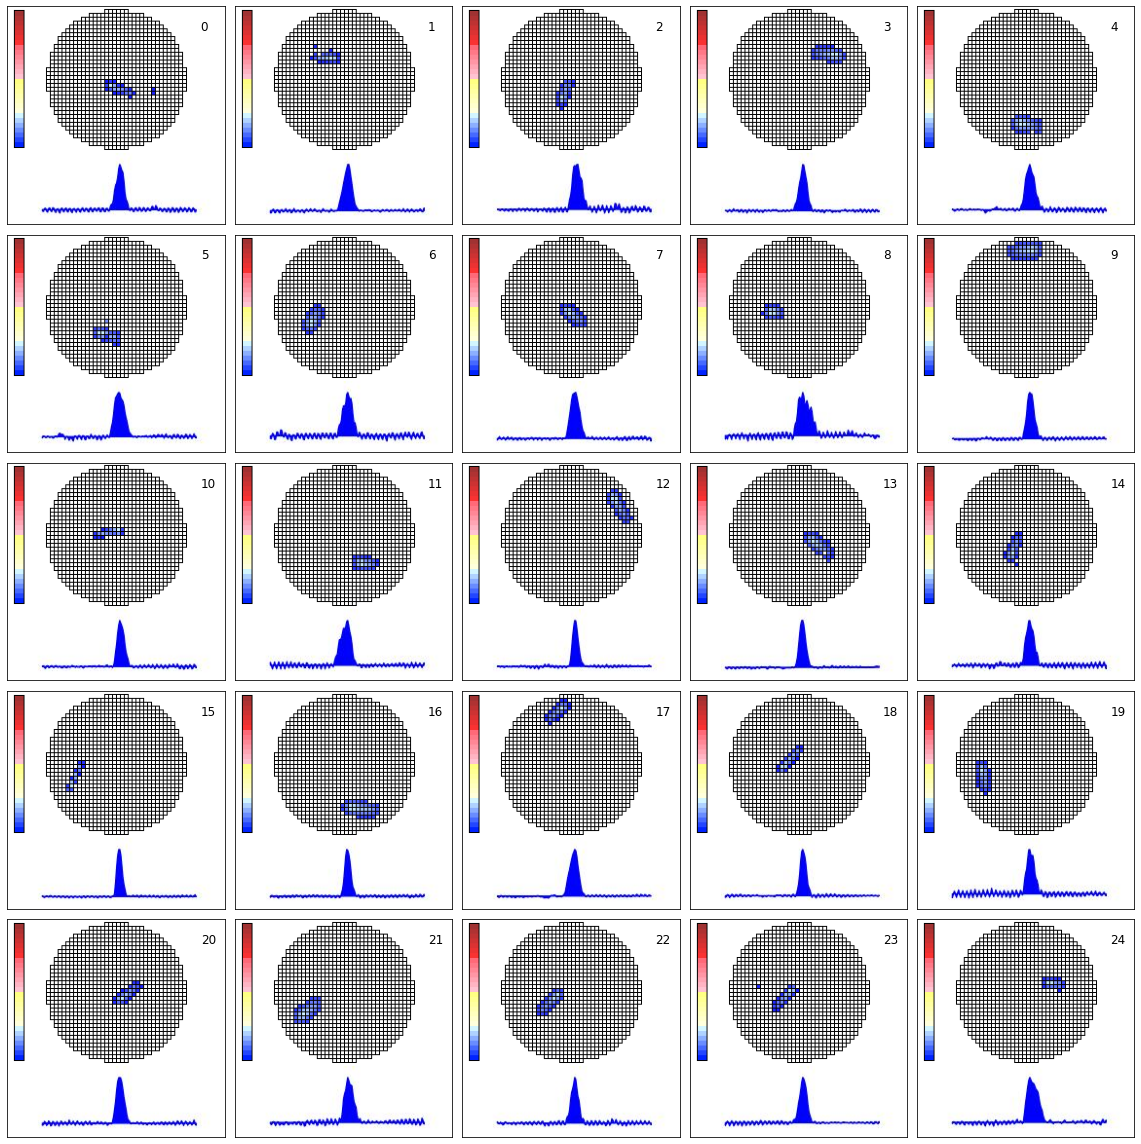

In [24]:
# View grid of images
NUM_ROWS = 5
IMGs_IN_ROW = 5
f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(16,16))

index = 0

for i in range(10):
    for j in range(10):
        try:
            ax[i][j].imshow(image[index])
            ax[i][j].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
            ax[i][j].annotate(f'{index}', xy = (0.89, 0.89), xycoords = "axes fraction", fontsize =12)
            index += 1
        except:
            break

print(f'Index to use for next for batch: {index}')
plt.tight_layout()

# save grid of images to file
plt.savefig('image_grid.png', dpi=300, bbox_inches='tight')

plt.show()


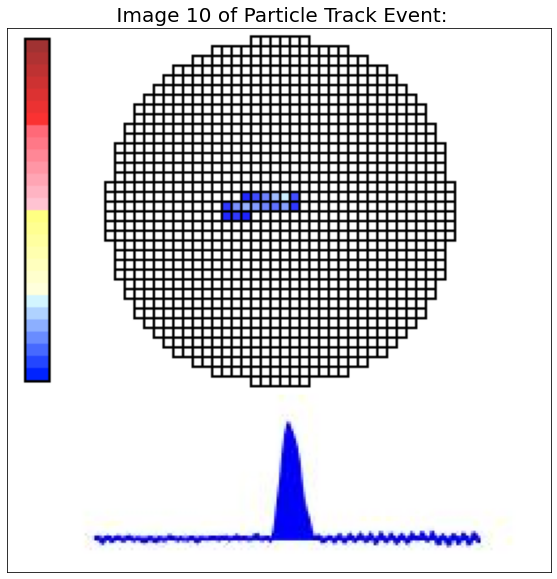

In [25]:
# Specify image you want to view
image_num = 10

# Plot images 
title = "Particle Track"
plt.rcParams['figure.figsize'] = [10, 10]
plt.title(f' Image {image_num} of {title} Event:', fontdict = {'fontsize' : 20})
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.imshow(image[image_num])
plt.show()

In [26]:
h5file.close()